# plot ekman pumping in easterlies experiment .. as a function of outcropping density class

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
import xgcm

import xesmf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37559/status,
Dashboard: /proxy/37559/status,Workers: 4
Total threads: 8,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41681,Workers: 4
Dashboard: /proxy/37559/status,Total threads: 8
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:40841,Total threads: 2
Dashboard: /proxy/38011/status,Memory: 25.00 GiB
Nanny: tcp://127.0.0.1:36297,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

expt=control

In [5]:
variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1)
area_t.load()
print(area_t.shape)

variable='xu_ocean'
xu_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xu_ocean.load()
print(xu_ocean.shape)

variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xt_ocean.load()
print(xt_ocean.shape)

(2700, 3600)
(3600,)
(3600,)


In [6]:
# years 6-10 of simulation:
start_time='2155-01-01'
end_time='2159-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-60.0) #-50.04-

In [7]:
# topography data for plotting:
ht = cc.querying.getvar(expt,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)

(640,)


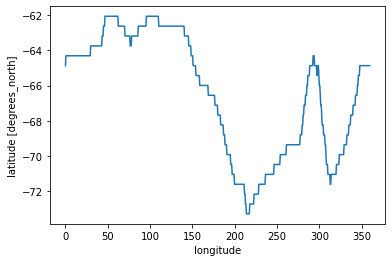

In [8]:
#make 0 windspeed area mask
#this is from windspeed input on jra grid 320 x640 - from fig. 1
fi = '/home/561/pas561/gdv45/jnb/easterlies-collaborative-project/notebooks/figures/tx0_smoothed.nc'
tx0 = xr.open_dataset(fi, decode_times = False).latitude[1:]
print(tx0.latitude.shape)
tx0.latitude.plot()

In [9]:
#regrid from jra to yt_ocean: 641 to 3600
#first change longitude from 0:360 to -280:80
#for 0-360
tx0['_lon_adj'] = xr.where(tx0['longitude'] > 80, tx0['longitude'] - 360, tx0['longitude'])

tx0 = tx0.swap_dims({'longitude': '_lon_adj'})
tx0 = tx0.sel(**{'_lon_adj': sorted(tx0._lon_adj)}).drop('longitude')
tx0 = tx0.rename({'_lon_adj': 'longitude'})

#now regrid it to xu_ocean
tx0_01=tx0.interp(longitude=xt_ocean)

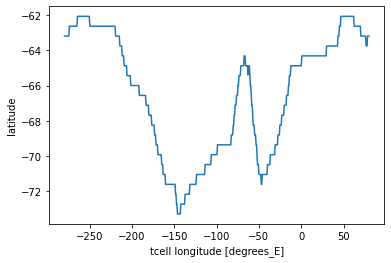

In [10]:
tx0_01.latitude.plot()

In [11]:
#mask tx=0 region
tx0mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht.yt_ocean>tx0_01.latitude)))
tx0mask = ~xr.ufuncs.isnan(tx0mask).to_dataset(name='tx0mask')
tx0area=area_t.where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()


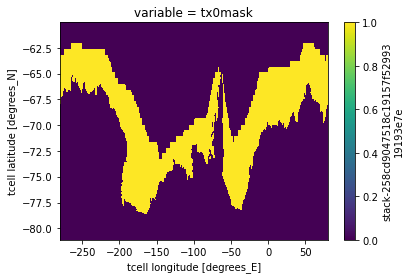

In [12]:
tx0mask=tx0mask.to_array()
tx0mask.plot()

In [14]:
tx0mask.to_netcdf('tx0mask.nc')

In [15]:
tx0mask

<xarray.DataArray 'stack-258cd9047518c19157f5299319193e7e' (variable: 1, yt_ocean: 490, xt_ocean: 3600)>
dask.array<stack, shape=(1, 490, 3600), dtype=bool, chunksize=(1, 490, 900), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
    latitude   (xt_ocean) float64 nan nan nan nan ... -63.18 -63.18 -63.18 nan
    longitude  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * variable   (variable) <U7 'tx0mask'

In [17]:
# last 5 years of simulation:
start_time='2155-01-01'
end_time='2159-12-31'
#end_time='2150-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-59.0) #-50.04-

In [18]:
ekman_con=xr.open_dataset('../Ekman_pumping/ekmanpump_control_sigma02155-2159.nc').mean(dim='year')
ekman_up=xr.open_dataset('../Ekman_pumping/ekmanpump_up_sigma02155-2159.nc').mean(dim='year')
ekman_down=xr.open_dataset('../Ekman_pumping/ekmanpump_down_sigma02155-2159.nc').mean(dim='year')

In [19]:
ekman_upz=xr.open_dataset('../Ekman_pumping/ekmanpump_upz_sigma02155-2159.nc').mean(dim='year') #*-1 d_dy_tauxf
ekman_upm=xr.open_dataset('../Ekman_pumping/ekmanpump_upm_sigma02155-2159.nc').mean(dim='year') #d_dx_tauyf

In [20]:
ekman_uptx=xr.open_dataset('../Ekman_pumping/ekmanpump_up_sigma0d_dy_tauxf2155-2159.nc').mean(dim='year')*-1 
ekman_upty=xr.open_dataset('../Ekman_pumping/ekmanpump_up_sigma0d_dx_tauyf2155-2159.nc').mean(dim='year') #

#ekmanpump_up_sigma0d_dy_tauxf2155-2159.nc


In [21]:
ekman_upz

<xarray.Dataset>
Dimensions:         (isopycnal_bins: 82, yt_ocean: 490, xt_ocean: 3600)
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 25.02 25.08 25.12 ... 29.03 29.08
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.1 -60.05
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
Data variables:
    ekman_sigma0    (isopycnal_bins, yt_ocean, xt_ocean) float64 nan nan ... nan

# area integrate each rho class

In [22]:
ekman_con_tx0_aint=(ekman_con.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_tx0_aint=(ekman_up.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

ekman_upz_tx0_aint=(ekman_upz.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_tx0_aint=(ekman_upm.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

ekman_uptx_tx0_aint=(ekman_uptx.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upty_tx0_aint=(ekman_upty.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

ekman_down_tx0_aint=(ekman_down.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

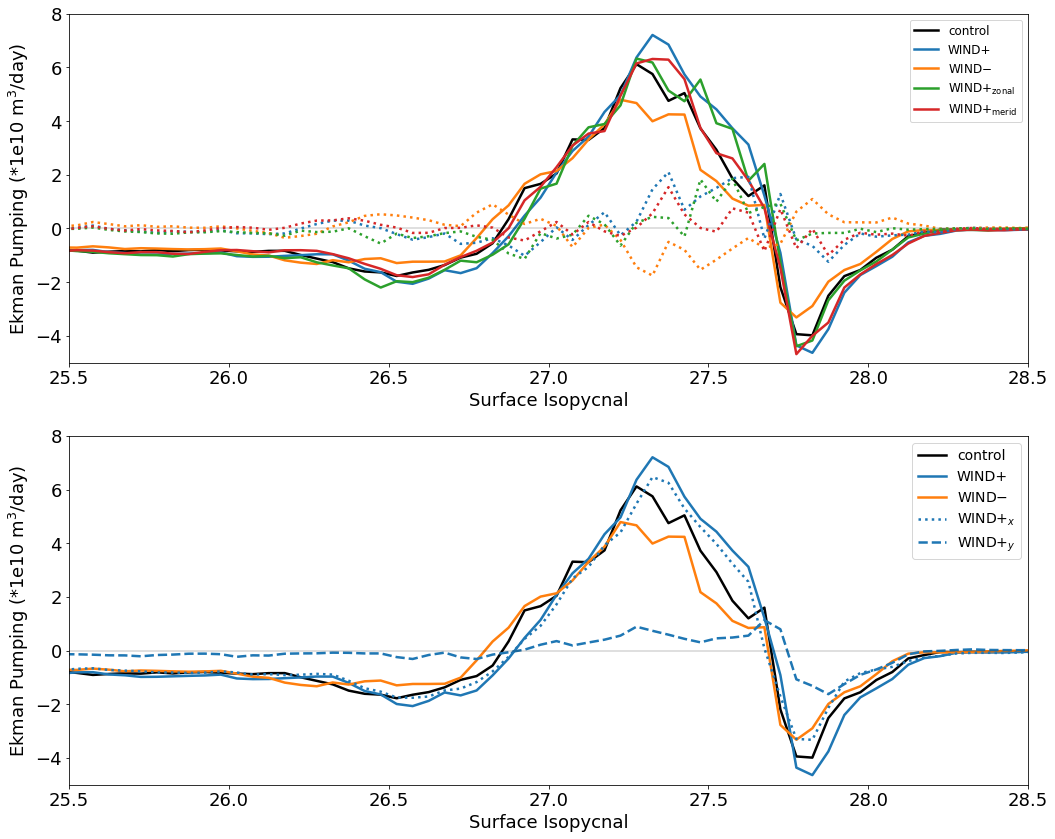

In [23]:
fontsize=18
plt.rcParams['font.size'] = fontsize

plt.figure(figsize=(15,12))

plt.subplot(211)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint/1E10,linestyle='-',color='k',label='control',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_tx0_aint/1E10,linestyle='-',color='C0',label='WIND+',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_tx0_aint/1E10,linestyle='-',color='C1',label='WIND$-$',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_tx0_aint/1E10,linestyle='-',color='C2',label='WIND+$_\mathrm{zonal}$',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_tx0_aint/1E10,linestyle='-',color='C3',label='WIND+$_\mathrm{merid}$',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)

plt.plot(ekman_con.isopycnal_bins,(ekman_up_tx0_aint-ekman_con_tx0_aint)/1E10,linestyle=':',color='C0',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,(ekman_down_tx0_aint-ekman_con_tx0_aint)/1E10,linestyle=':',color='C1',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,(ekman_upz_tx0_aint-ekman_con_tx0_aint)/1E10,linestyle=':',color='C2',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,(ekman_upm_tx0_aint-ekman_con_tx0_aint)/1E10,linestyle=':',color='C3',linewidth=2.5)

plt.xlim((25.5,28.5))
plt.ylim((-5,8))
plt.ylabel('Ekman Pumping (*1e10 m$^3$/day)')
plt.xlabel('Surface Isopycnal')
#plt.xlim([-75,85])
#plt.title('Ekman pumping area integrated in wind perturbation zone')
plt.legend(fontsize=12, loc="upper right")

plt.subplot(212)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint/1E10,linestyle='-',color='k',label='control',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_tx0_aint/1E10,linestyle='-',color='C0',label='WIND+',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_tx0_aint/1E10,linestyle='-',color='C1',label='WIND$-$',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,ekman_uptx_tx0_aint/1E10,linestyle=':',color='C0',label='WIND+$_x$',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upty_tx0_aint/1E10,linestyle='--',color='C0',label='WIND+$_y$',linewidth=2.5)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
plt.xlim((25.5,28.5))
plt.ylim((-5,8))
plt.ylabel('Ekman Pumping (*1e10 m$^3$/day)')
plt.xlabel('Surface Isopycnal')
#plt.xlim([-75,85])
#plt.title('Ekman pumping area integrated in wind perturbation zone')
plt.legend(fontsize=14, loc="upper right")

plt.subplots_adjust(hspace = 0.05)

plt.tight_layout()

plt.savefig('Figure9.pdf',bbox_inches = 'tight')

In [24]:
np.save('../Ekman_pumping/ekman_con_tx0_aint.npy',ekman_con_tx0_aint)
np.save('../Ekman_pumping/ekman_up_tx0_aint.npy',ekman_up_tx0_aint)
np.save('../Ekman_pumping/ekman_down_tx0_aint.npy',ekman_down_tx0_aint)